In [17]:
import numpy as np
import pandas as pd
import json as json
import re
import nltk
import openai
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sentence_transformers import SentenceTransformer
from sentence_transformers import util
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/benmischeck/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
api_key = "XXXX"
client = openai.OpenAI(api_key=api_key)

In [ ]:
# Import csv file with pre-cleaned ideas from survey 
df_survey_ideas = pd.read_csv("XXXXX/Survey_ideas_clean.csv")

# Filter df to continue only with needed columns
columns_to_select = ['Response ID','idea_elaboration', 'GroupAssignment', 'Task2_ChatGPT_Access', 'Task2_ChatGPT_Interaction','DAT_score','BusinessFamilarity', 'EngExp','InnoMgmtExp','SustainabilityExp', 'GenAIExp', 'GenAIFrequency', 'Age', 'Gender', 'Education', 'Employment', 'ProfField']
df_survey_ideas = df_survey_ideas[columns_to_select]

display(df_survey_ideas)

,Response ID,idea_elaboration,GroupAssignment,Task2_ChatGPT_Access,Task2_ChatGPT_Interaction,DAT_score,BusinessFamilarity,EngExp,InnoMgmtExp,SustainabilityExp,GenAIExp,GenAIFrequency,Age,Gender,Education,Employment,ProfField
0,R_2MeVhGrthluSOHf,A Smart outlet helps save electricity by autom...,Human_Human,0,0,78.535901,Somewhat familiar,Advanced (C1),Basic experience,Basic experience,Basic experience,Frequently (1-3x per week),25–34,Female,Bachelor's Degree,Student,"Business, Economics, & Management"
1,R_2I6tZ6LTbfYc0GX,Shoes made of ocean plastic would reduce the w...,Human/AI_Human,0,0,77.496777,Extremely familiar,Advanced (C1),Basic experience,Basic experience,Practical experience,Frequently (1-3x per week),25–34,Female,Master's Degree,Employed full-time,"Business, Economics, & Management"
2,R_2y8eiKbpPQCPHiI,Reusable water bottles can be a key component ...,Human/AI_Human/AI,1,1,78.237401,Somewhat familiar,Advanced (C1),Basic experience,Professional experience,Practical experience,Frequently (1-3x per week),25–34,Male,Bachelor's Degree,Student,"Business, Economics, & Management"
3,R_8X68xD9TOB81k0E,Core Concept: reuseable bags to minimize envir...,Human_Human/AI,1,1,79.926777,Very familiar,Advanced (C1),Practical experience,Basic experience,Practical experience,Daily or almost daily,18–24,Female,Master's Degree,Employed full-time,"Business, Economics, & Management"
4,R_8dj9aA2If4L0AXS,Community Solar sharing is a decentralized ene...,Human/AI_Human,0,0,81.771145,Somewhat familiar,Advanced (C1),Basic experience,Practical experience,Practical experience,Daily or almost daily,25–34,Male,Master's Degree,Employed full-time,"Business, Economics, & Management"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,R_2a9zoHexe3ldLWW,Urban Vertical Farming Solutions focuses on re...,Human/AI_Human/AI,1,1,74.677366,Somewhat familiar,Near-Native (C2),Minimal experience,Basic experience,Practical experience,Daily or almost daily,25–34,Male,Bachelor's Degree,Employed full-time,"Business, Economics, & Management"
101,R_6rffg9jG4P5uv8C,Sustainable cooking classes are offered to peo...,Human/AI_Human,0,0,81.616391,Very familiar,Near-Native (C2),Minimal experience,Practical experience,Basic experience,Frequently (1-3x per week),35–44,Female,Master's Degree,Employed full-time,Education & Teaching
102,R_2EiEFoosaRZCH8b,"A new innovative way to install pavement, e.g....",Human_Human,0,0,79.499761,Somewhat familiar,Near-Native (C2),Minimal experience,Basic experience,Basic experience,Frequently (1-3x per week),25–34,Male,Bachelor's Degree,Employed full-time,Engineering & Technology
103,R_6j98PldVIBCiuBX,Smart Weather-Integrated Garden Sprinkling Sys...,Human_Human/AI,1,1,77.619768,Slightly familiar,Near-Native (C2),No experience,Basic experience,Minimal experience,Rarely (less than once month),18–24,Female,Bachelor's Degree,Employed full-time,Health Sciences & Medicine


In [20]:
# Create function to create vectors using OpenAI embedding model
def get_openai_embedding(text):
    response = client.embeddings.create(
        input=text,
        model="text-embedding-3-small"
    )
    return response.data[0].embedding 

# Create function to calculate the cohesion score of various sentences
def cohesion_score(text):
    sentences = sent_tokenize(text)
    if len(sentences) < 2:
        return 1.0  
    embeddings = np.array([get_openai_embedding(sent) for sent in sentences])
    similarity_matrix = cosine_similarity(embeddings)
    n = len(sentences)
    # Calculate the cohesion of the description using the average
    cohesion = (np.sum(similarity_matrix) - n) / (n * (n - 1)) 
    return cohesion

In [21]:
# Calculate cohesion score for each idea elaboration
df_survey_ideas["idea_cohesion"] = df_survey_ideas["idea_elaboration"].apply(cohesion_score)
display(df_survey_ideas.head())

,Response ID,idea_elaboration,GroupAssignment,Task2_ChatGPT_Access,Task2_ChatGPT_Interaction,DAT_score,BusinessFamilarity,EngExp,InnoMgmtExp,SustainabilityExp,GenAIExp,GenAIFrequency,Age,Gender,Education,Employment,ProfField,idea_cohesion
0,R_2MeVhGrthluSOHf,A Smart outlet helps save electricity by autom...,Human_Human,0,0,78.535901,Somewhat familiar,Advanced (C1),Basic experience,Basic experience,Basic experience,Frequently (1-3x per week),25–34,Female,Bachelor's Degree,Student,"Business, Economics, & Management",0.396103
1,R_2I6tZ6LTbfYc0GX,Shoes made of ocean plastic would reduce the w...,Human/AI_Human,0,0,77.496777,Extremely familiar,Advanced (C1),Basic experience,Basic experience,Practical experience,Frequently (1-3x per week),25–34,Female,Master's Degree,Employed full-time,"Business, Economics, & Management",0.524760
2,R_2y8eiKbpPQCPHiI,Reusable water bottles can be a key component ...,Human/AI_Human/AI,1,1,78.237401,Somewhat familiar,Advanced (C1),Basic experience,Professional experience,Practical experience,Frequently (1-3x per week),25–34,Male,Bachelor's Degree,Student,"Business, Economics, & Management",0.494565
3,R_8X68xD9TOB81k0E,Core Concept: reuseable bags to minimize envir...,Human_Human/AI,1,1,79.926777,Very familiar,Advanced (C1),Practical experience,Basic experience,Practical experience,Daily or almost daily,18–24,Female,Master's Degree,Employed full-time,"Business, Economics, & Management",1.000000
4,R_8dj9aA2If4L0AXS,Community Solar sharing is a decentralized ene...,Human/AI_Human,0,0,81.771145,Somewhat familiar,Advanced (C1),Basic experience,Practical experience,Practical experience,Daily or almost daily,25–34,Male,Master's Degree,Employed full-time,"Business, Economics, & Management",0.409685


In [22]:
# import csv file with pre-cleaned survey answers from ChatGPT
df_chatgpt = pd.read_csv("/Users/benmischeck/Library/Mobile Documents/com~apple~CloudDocs/Uni/Master_Uni-Köln/WS2024 Master Thesis/Final/Data Analysis/Data/Pre-processed/chatgpt_survey_responses_cleaned.csv")

# Calculate cohesion score for each idea elaboration
df_chatgpt['idea_cohesion'] = df_chatgpt['Task2'].apply(cohesion_score)

In [23]:
# Compute the average for all 3 groups
avg_idea_cohesion = df_survey_ideas.groupby('Task2_ChatGPT_Access')["idea_cohesion"].mean()
chatgpt_avg_idea_cohesion = df_chatgpt['idea_cohesion'].mean()

print("Mean Idea cohesion score", avg_idea_cohesion)
print("Mean Idea cohesion of ChatGPT:", chatgpt_avg_idea_cohesion)

Mean Idea cohesion score Task2_ChatGPT_Access
0    0.438518
1    0.503286
Name: idea_cohesion, dtype: float64
Mean Idea cohesion of ChatGPT: 0.5108311695776713


In [24]:
# Correlation calculation
correlation = df_survey_ideas["idea_cohesion"].corr(df_survey_ideas["Task2_ChatGPT_Access"])
print(f"Correlation between cosine similarity and Task2_ChatGPT_Access: {correlation:.3f}")

# Define the OLS model
X = df_survey_ideas["idea_cohesion"]
X = sm.add_constant(X)  # Adds an intercept term
y = df_survey_ideas["Task2_ChatGPT_Access"]
model = sm.OLS(y, X).fit()

print(model.summary())

Correlation between cosine similarity and Task2_ChatGPT_Access: 0.263
                             OLS Regression Results                             
Dep. Variable:     Task2_ChatGPT_Access   R-squared:                       0.069
Model:                              OLS   Adj. R-squared:                  0.060
Method:                   Least Squares   F-statistic:                     7.676
Date:                  Sun, 13 Apr 2025   Prob (F-statistic):            0.00664
Time:                          11:00:14   Log-Likelihood:                -72.201
No. Observations:                   105   AIC:                             148.4
Df Residuals:                       103   BIC:                             153.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

Correlation between ChatGPT access (Task 2) and idea cohesion: 0.263
                            OLS Regression Results                            
Dep. Variable:          idea_cohesion   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     7.676
Date:                Sun, 13 Apr 2025   Prob (F-statistic):            0.00664
Time:                        11:00:14   Log-Likelihood:                 75.083
No. Observations:                 105   AIC:                            -146.2
Df Residuals:                     103   BIC:                            -140.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

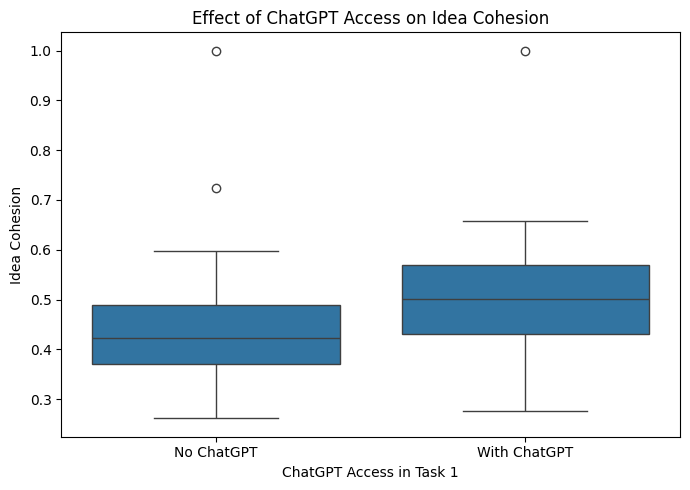

In [25]:
# Compute correlation scores
correlation = df_survey_ideas["idea_cohesion"].corr(df_survey_ideas["Task2_ChatGPT_Access"])
print(f"Correlation between ChatGPT access (Task 2) and idea cohesion: {correlation:.3f}")

# Define OLS model
X = df_survey_ideas["Task2_ChatGPT_Access"] 
X = sm.add_constant(X)
y = df_survey_ideas["idea_cohesion"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot group diffrencse
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Access", y="idea_cohesion", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 1")
plt.ylabel("Idea Cohesion")
plt.title("Effect of ChatGPT Access on Idea Cohesion")
plt.tight_layout()
plt.show()


Correlation between ChatGPT access (Task 2) and idea cohesion: 0.340
                            OLS Regression Results                            
Dep. Variable:          idea_cohesion   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     13.49
Date:                Sun, 13 Apr 2025   Prob (F-statistic):           0.000382
Time:                        11:00:14   Log-Likelihood:                 77.771
No. Observations:                 105   AIC:                            -151.5
Df Residuals:                     103   BIC:                            -146.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------

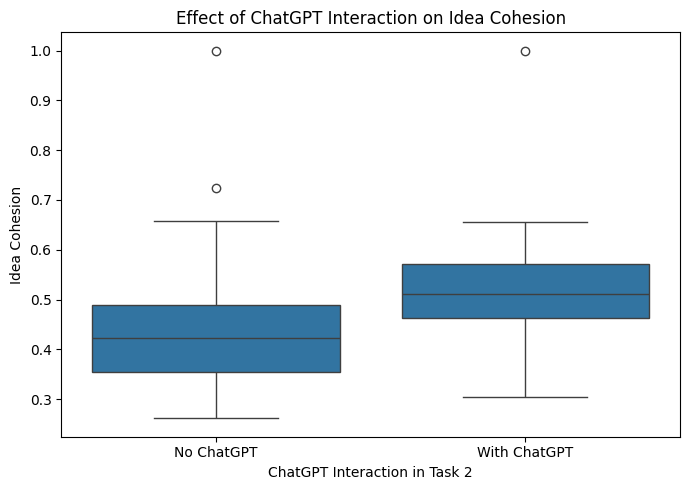

In [26]:
# Compute correlation scores
correlation = df_survey_ideas["idea_cohesion"].corr(df_survey_ideas["Task2_ChatGPT_Interaction"])
print(f"Correlation between ChatGPT access (Task 2) and idea cohesion: {correlation:.3f}")

# Define OLS model
X = df_survey_ideas["Task2_ChatGPT_Interaction"] 
X = sm.add_constant(X)
y = df_survey_ideas["idea_cohesion"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot group diffrencse
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="idea_cohesion", data=df_survey_ideas)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 2")
plt.ylabel("Idea Cohesion")
plt.title("Effect of ChatGPT Interaction on Idea Cohesion")
plt.tight_layout()
plt.show()


In [27]:
# dummy encoding of all relevant control variables
df_survey_ideas['BusinessFamiliarity_High'] = df_survey_ideas['BusinessFamilarity'].apply(lambda x: 1 if x in ['Very familiar', 'Extremely familiar'] else 0)
df_survey_ideas['EngExp_High'] = df_survey_ideas['EngExp'].apply(lambda x: 1 if x in ['Near-Native (C2)', 'Native'] else 0)
df_survey_ideas['ProfField_Business'] = df_survey_ideas['ProfField'].apply(lambda x: 1 if x in ['Business, Economics, & Management'] else 0)
df_survey_ideas['InnoMgmtExp_High'] = df_survey_ideas['InnoMgmtExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['SustainabilityExp_High'] = df_survey_ideas['SustainabilityExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['GenAIExp_High'] = df_survey_ideas['GenAIExp'].apply(lambda x: 1 if x in ['Practical experience', 'Professional experience'] else 0)
df_survey_ideas['GenAIFrequency_High'] = df_survey_ideas['GenAIFrequency'].apply(lambda x: 1 if x in ['Daily or almost daily', 'Frequently (1-3x per week)'] else 0)
df_survey_ideas['Age_35+'] = df_survey_ideas['Age'].apply(lambda x: 1 if x in ['35–44', '45-54', '55-64', '65 or older'] else 0)
df_survey_ideas['Gender_Male'] = df_survey_ideas['Gender'].apply(lambda x: 1 if x in ['Male'] else 0)

# standardize DAT score using z score
scaler = StandardScaler()
df_survey_ideas['DAT_score_standardized'] = scaler.fit_transform(df_survey_ideas[['DAT_score']])

display(df_survey_ideas)

,Response ID,idea_elaboration,GroupAssignment,Task2_ChatGPT_Access,Task2_ChatGPT_Interaction,DAT_score,BusinessFamilarity,EngExp,InnoMgmtExp,SustainabilityExp,...,BusinessFamiliarity_High,EngExp_High,ProfField_Business,InnoMgmtExp_High,SustainabilityExp_High,GenAIExp_High,GenAIFrequency_High,Age_35+,Gender_Male,DAT_score_standardized
0,R_2MeVhGrthluSOHf,A Smart outlet helps save electricity by autom...,Human_Human,0,0,78.535901,Somewhat familiar,Advanced (C1),Basic experience,Basic experience,...,0,0,1,0,0,0,1,0,0,0.037129
1,R_2I6tZ6LTbfYc0GX,Shoes made of ocean plastic would reduce the w...,Human/AI_Human,0,0,77.496777,Extremely familiar,Advanced (C1),Basic experience,Basic experience,...,1,0,1,0,0,1,1,0,0,-0.302395
2,R_2y8eiKbpPQCPHiI,Reusable water bottles can be a key component ...,Human/AI_Human/AI,1,1,78.237401,Somewhat familiar,Advanced (C1),Basic experience,Professional experience,...,0,0,1,0,1,1,1,0,1,-0.060403
3,R_8X68xD9TOB81k0E,Core Concept: reuseable bags to minimize envir...,Human_Human/AI,1,1,79.926777,Very familiar,Advanced (C1),Practical experience,Basic experience,...,1,0,1,1,0,1,1,0,0,0.491586
4,R_8dj9aA2If4L0AXS,Community Solar sharing is a decentralized ene...,Human/AI_Human,0,0,81.771145,Somewhat familiar,Advanced (C1),Basic experience,Practical experience,...,0,0,1,0,1,1,1,0,1,1.094216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,R_2a9zoHexe3ldLWW,Urban Vertical Farming Solutions focuses on re...,Human/AI_Human/AI,1,1,74.677366,Somewhat familiar,Near-Native (C2),Minimal experience,Basic experience,...,0,1,1,0,0,1,1,0,1,-1.223613
101,R_6rffg9jG4P5uv8C,Sustainable cooking classes are offered to peo...,Human/AI_Human,0,0,81.616391,Very familiar,Near-Native (C2),Minimal experience,Practical experience,...,1,1,0,0,1,0,1,1,0,1.043652
102,R_2EiEFoosaRZCH8b,"A new innovative way to install pavement, e.g....",Human_Human,0,0,79.499761,Somewhat familiar,Near-Native (C2),Minimal experience,Basic experience,...,0,1,0,0,0,0,1,0,1,0.352062
103,R_6j98PldVIBCiuBX,Smart Weather-Integrated Garden Sprinkling Sys...,Human_Human/AI,1,1,77.619768,Slightly familiar,Near-Native (C2),No experience,Basic experience,...,0,1,0,0,0,0,0,0,0,-0.262209


                            OLS Regression Results                            
Dep. Variable:          idea_cohesion   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     1.913
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0667
Time:                        11:00:15   Log-Likelihood:                 79.073
No. Observations:                 105   AIC:                            -140.1
Df Residuals:                      96   BIC:                            -116.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

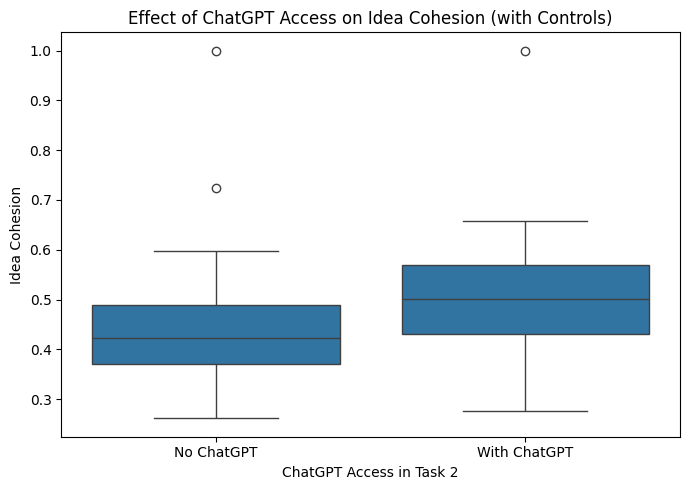

In [28]:
# Idea Cohesion + Task2_Access + Controls

# define control variables
predictors = [
    'Task2_ChatGPT_Access',
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# drop N/A
df = df_survey_ideas.dropna(subset=predictors + ["idea_cohesion"])


# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_cohesion"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Access", y="idea_cohesion", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Access in Task 2")
plt.ylabel("Idea Cohesion")
plt.title("Effect of ChatGPT Access on Idea Cohesion (with Controls)")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:          idea_cohesion   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.695
Date:                Sun, 13 Apr 2025   Prob (F-statistic):             0.0102
Time:                        11:00:15   Log-Likelihood:                 81.947
No. Observations:                 105   AIC:                            -145.9
Df Residuals:                      96   BIC:                            -122.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

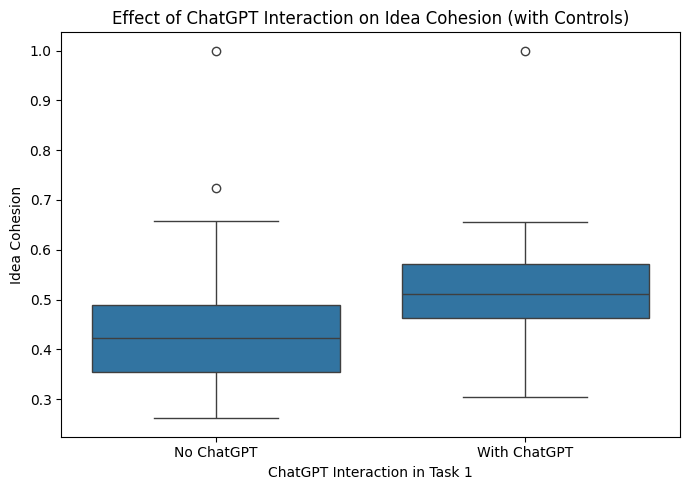

In [29]:
# Idea Cohesion + Task2_Interaction + Controls

# define control variables
predictors = [
    'Task2_ChatGPT_Interaction', 
    'DAT_score_standardized',
    'BusinessFamiliarity_High',
    'EngExp_High', 
    'InnoMgmtExp_High', 
    'SustainabilityExp_High', 
    'GenAIExp_High',  
    'Gender_Male'
]

# Drop N/A 
df = df_survey_ideas.dropna(subset=predictors + ["idea_cohesion"])

# design OLS regression
X = df[predictors].apply(pd.to_numeric, errors='coerce')
X = X.astype(float)
X = sm.add_constant(X)
y = df["idea_cohesion"]
model = sm.OLS(y, X).fit()

print(model.summary())

# box plot showing differences
plt.figure(figsize=(7, 5))
sns.boxplot(x="Task2_ChatGPT_Interaction", y="idea_cohesion", data=df)
plt.xticks([0, 1], ['No ChatGPT', 'With ChatGPT'])
plt.xlabel("ChatGPT Interaction in Task 1")
plt.ylabel("Idea Cohesion")
plt.title("Effect of ChatGPT Interaction on Idea Cohesion (with Controls)")
plt.tight_layout()
plt.show()


In [30]:
df_survey_ideas_2 = df_survey_ideas[['Response ID','idea_elaboration', 'GroupAssignment', 'idea_cohesion']]
df_chatgpt_2 = df_chatgpt[['Iteration', 'Task2', 'idea_cohesion']]
df_chatgpt_2['GroupAssignment'] = "AI_AI"
df_chatgpt_2 = df_chatgpt_2.rename(columns={'Iteration': 'Response ID', 'Task2': 'idea_elaboration'})

df_summary = pd.concat([df_survey_ideas_2, df_chatgpt_2], ignore_index=True)

/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_23745/1812400012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chatgpt_2['GroupAssignment'] = "AI_AI"


/var/folders/5v/5dqtcjd96y72ntf_gbypdffm0000gn/T/ipykernel_23745/1046721544.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


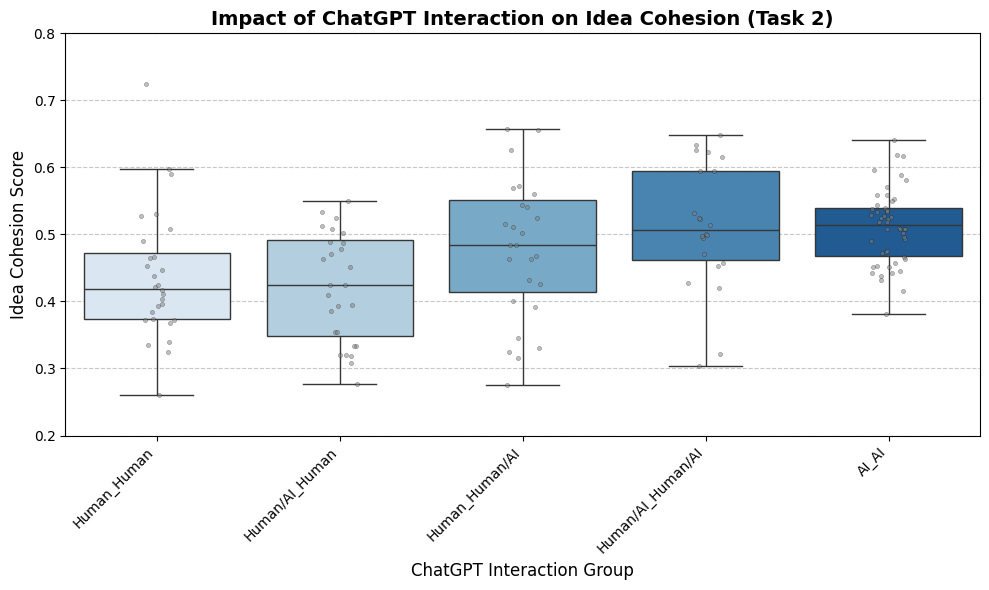

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define general plot set-up
plt.figure(figsize=(10, 6))
group_order = ["Human_Human", "Human/AI_Human", "Human_Human/AI", "Human/AI_Human/AI", "AI_AI"]

# Boxplot for mean and spread
sns.boxplot(
    x="GroupAssignment",
    y="idea_cohesion",
    data=df_summary,
    order=group_order,
    palette="Blues",
    showfliers=False
)

# Stripplot for raw data points
sns.stripplot(
    x="GroupAssignment",
    y="idea_cohesion",
    data=df_summary,
    order=group_order,
    jitter=True,
    dodge=True,
    size=3,
    alpha=0.5,
    color='gray',
    edgecolor='black',
    linewidth=0.3
)

# Plot details
plt.xticks(rotation=45, ha='right')
plt.xlabel("ChatGPT Interaction Group", fontsize=12)
plt.ylabel("Idea Cohesion Score", fontsize=12)
plt.title("Impact of ChatGPT Interaction on Idea Cohesion (Task 2)", fontsize=14, fontweight='bold')
plt.ylim(0.2, 0.8) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
